# Linear regression using LASSO

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from utils import get_dataframe, get_astronomical_seasons

Load data:

In [29]:
df = get_dataframe(solar_noon_altitudes=True)

X = df.drop(['RSKF', 'Datum und Uhrzeit', 'Gesamtanlage[kWh]'], axis=1) # Remove categorial feature, date and dependent variable.
features = X.columns

scaler = StandardScaler()
scaler.fit(X)
X_standard = scaler.transform(X) # Standardize the features for correct regularization.

y = df['Gesamtanlage[kWh]']

Train linear regression model:

In [48]:
alpha = 0.3 # Regularization factor
reg = Lasso(alpha).fit(X_standard, y)

coefficients = pd.DataFrame(data=reg.coef_, index=features, columns=['all'])
print(coefficients)

print('Regularization factor: ', alpha)
print('R^2: ', reg.score(X_standard,y))

              all
FX       0.000000
FM       0.000000
RSK     -0.357448
SDK      6.780159
SHK_TAG  0.000000
NM      -0.000000
VPM     -0.000000
PM      -0.147877
TMK      0.313476
UPM     -0.042589
TXK      0.000000
TNK      0.000000
TGK      0.000000
SNA      7.356752
Regularization factor:  0.3
R^2:  0.9239487128177348


Plotting:

In [7]:
# Code taken from exploratory_analysis.ipynb and adapted:

In [33]:
from datetime import datetime

data = get_dataframe(solar_noon_altitudes=True)
# remove whitespace at beginning of column name
data.columns = [col.strip() for col in data.columns]
data.head()


# drop 29.02.2020 because there is no value in the other years to compare
data = data.drop(data[data['Datum und Uhrzeit'] == '29.02.2020'].index).reset_index()
data = data.drop('index', axis=1)

# add column for year, month and day of the year
# convert 'Datum und Uhrzeit' column to date
data['Date'] = [datetime.strptime(data['Datum und Uhrzeit'][i], '%d.%m.%Y') for i in range(len(data))]
data['Year'] = data['Date'].dt.year
data['Day of year'] = data['Date'].dt.dayofyear
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data.drop('Date', axis=1)

For 2019 the MSE is 12.10.
For 2020 the MSE is 13.86.
For 2021 the MSE is 12.99.
For 2022 the MSE is 14.68.


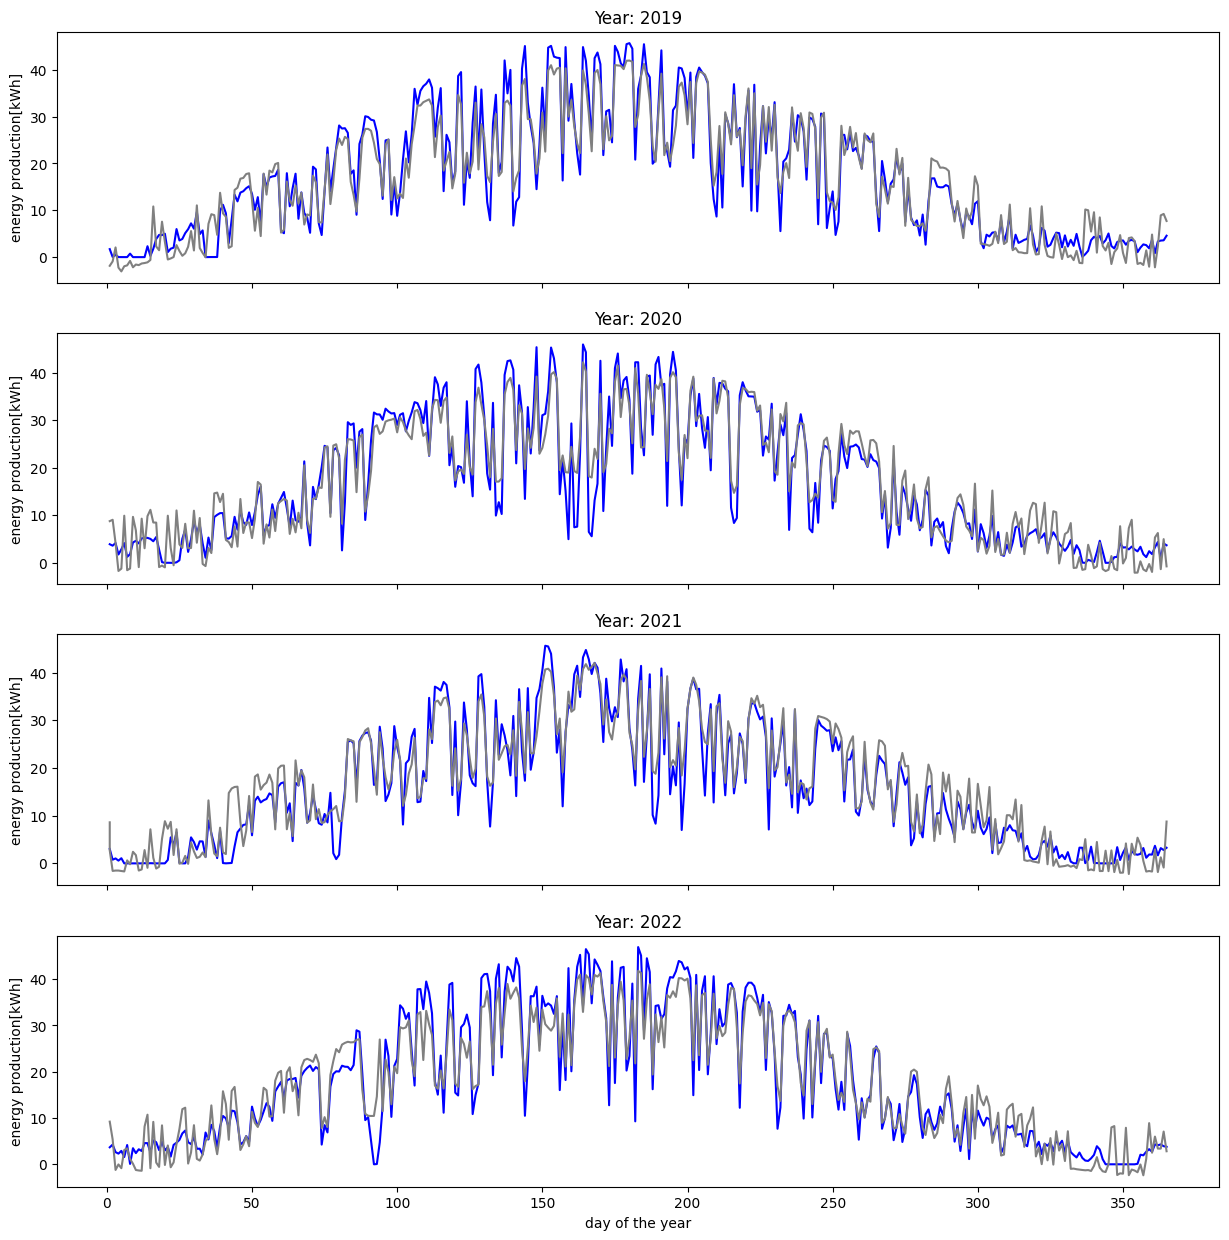

In [34]:
fig, axes = plt.subplots(4, 1, figsize=(15,15), sharex=True)
i = 0
for year in data['Year'].unique():
    ax = axes.flatten()[i]
    ax.set_title('Year: ' + str(year))
    year_data = data[data['Year'] == year]

    X = year_data.drop(['RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Month', 'Day', 'Gesamtanlage[kWh]'], axis=1)
    X = scaler.transform(X)

    # plot energy production
    ax.plot(
        year_data['Day of year'],
        year_data['Gesamtanlage[kWh]'],
        color='blue'
    )

    #plot predictions
    ax.plot(
        year_data['Day of year'],
        reg.predict(X),
        color='grey'
    )
        
    ax.set_ylabel('energy production[kWh]')
    i += 1


    # compute mean squared error:
    mse = mean_squared_error(year_data['Gesamtanlage[kWh]'], reg.predict(X))
    print(f'For {year} the MSE is {mse:.2f}.')

    
axes[3].set_xlabel('day of the year')
plt.show()

Regression for individual seasons:

In [92]:
seasons = ['winter', 'spring', 'summer', 'fall']
data['Season'] = data.apply(get_astronomical_seasons, axis=1)

In [93]:
reg_by_season = {}
X_by_season = {}
y_by_season = {}
scaler_by_season = {}

for season in seasons:

    data_season = data[data['Season'] == season]
    X_season = data_season.drop(['Season', 'RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Day', 'Month', 'Gesamtanlage[kWh]'], axis=1)
    scaler_season = StandardScaler()
    scaler_season.fit(X_season)
    X_season_standard = scaler_season.transform(X_season) # Standardize the features for correct regularization.
    y_season = data_season['Gesamtanlage[kWh]']

    alpha_season = alpha # Same regularization factor
    reg_season = Lasso(alpha_season).fit(X_season_standard, y_season)

    reg_by_season[season] = reg_season
    X_by_season[season] = X_season
    y_by_season[season] = y_season
    scaler_by_season[season] = scaler_season

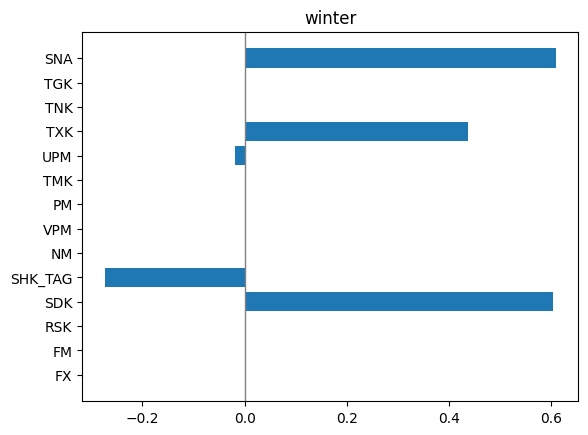

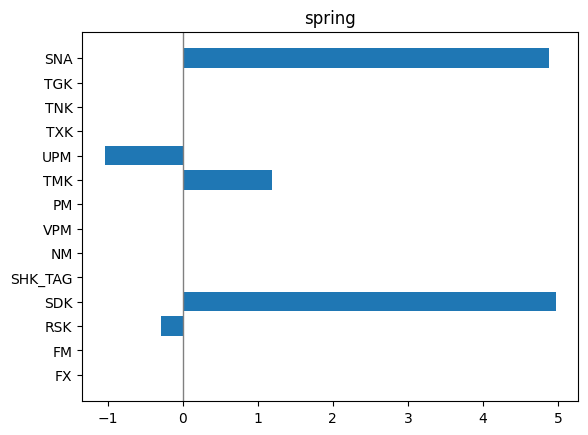

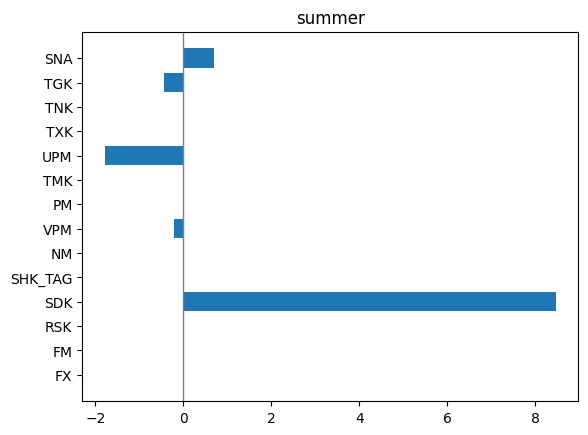

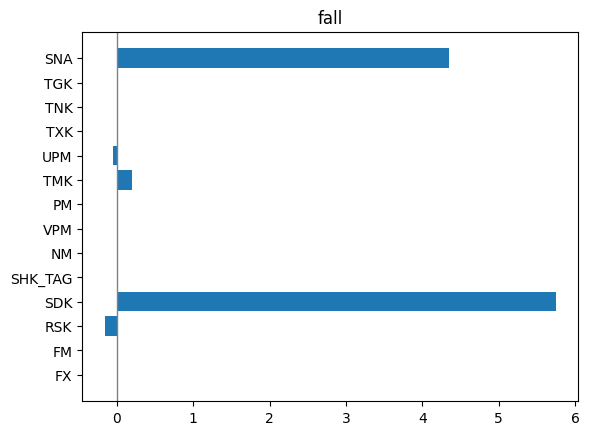

In [94]:
# https://stackoverflow.com/questions/28931224/how-to-add-value-labels-on-a-bar-chart

for season in seasons:
    weights = reg_by_season[season].coef_
    coefficients[season] = weights
    plt.barh(features, weights)

    plt.axvline(x = 0, color = 'gray', lw=1)
    plt.title(season)
    plt.show()

In [95]:
coefficients

,all,winter,spring,summer,fall
FX,0.000000,0.000000,0.000000,0.000000,0.000000
FM,0.000000,-0.000000,0.000000,0.000000,0.000000
RSK,-0.357448,-0.000000,-0.285218,-0.007924,-0.157340
SDK,6.780159,0.604800,4.970307,8.464662,5.746591
SHK_TAG,0.000000,-0.273867,0.000000,0.000000,-0.000000
NM,-0.000000,0.000000,0.000000,-0.000000,-0.000000
VPM,-0.000000,0.000000,0.000000,-0.199680,-0.000000
PM,-0.147877,-0.000000,-0.000000,0.000000,-0.000000
TMK,0.313476,0.000000,1.184752,-0.000000,0.203443
UPM,-0.042589,-0.019002,-1.039851,-1.784672,-0.043503


In [114]:
def reg_using_season(row):
    season = row['Season']
    sample = row.drop(['Season'])
    sample = scaler_by_season[season].transform(pd.DataFrame([sample]))
    return reg_by_season[season].predict(sample)

For 2019 the MSE is 7.26.
For 2020 the MSE is 7.08.
For 2021 the MSE is 7.23.
For 2022 the MSE is 9.25.


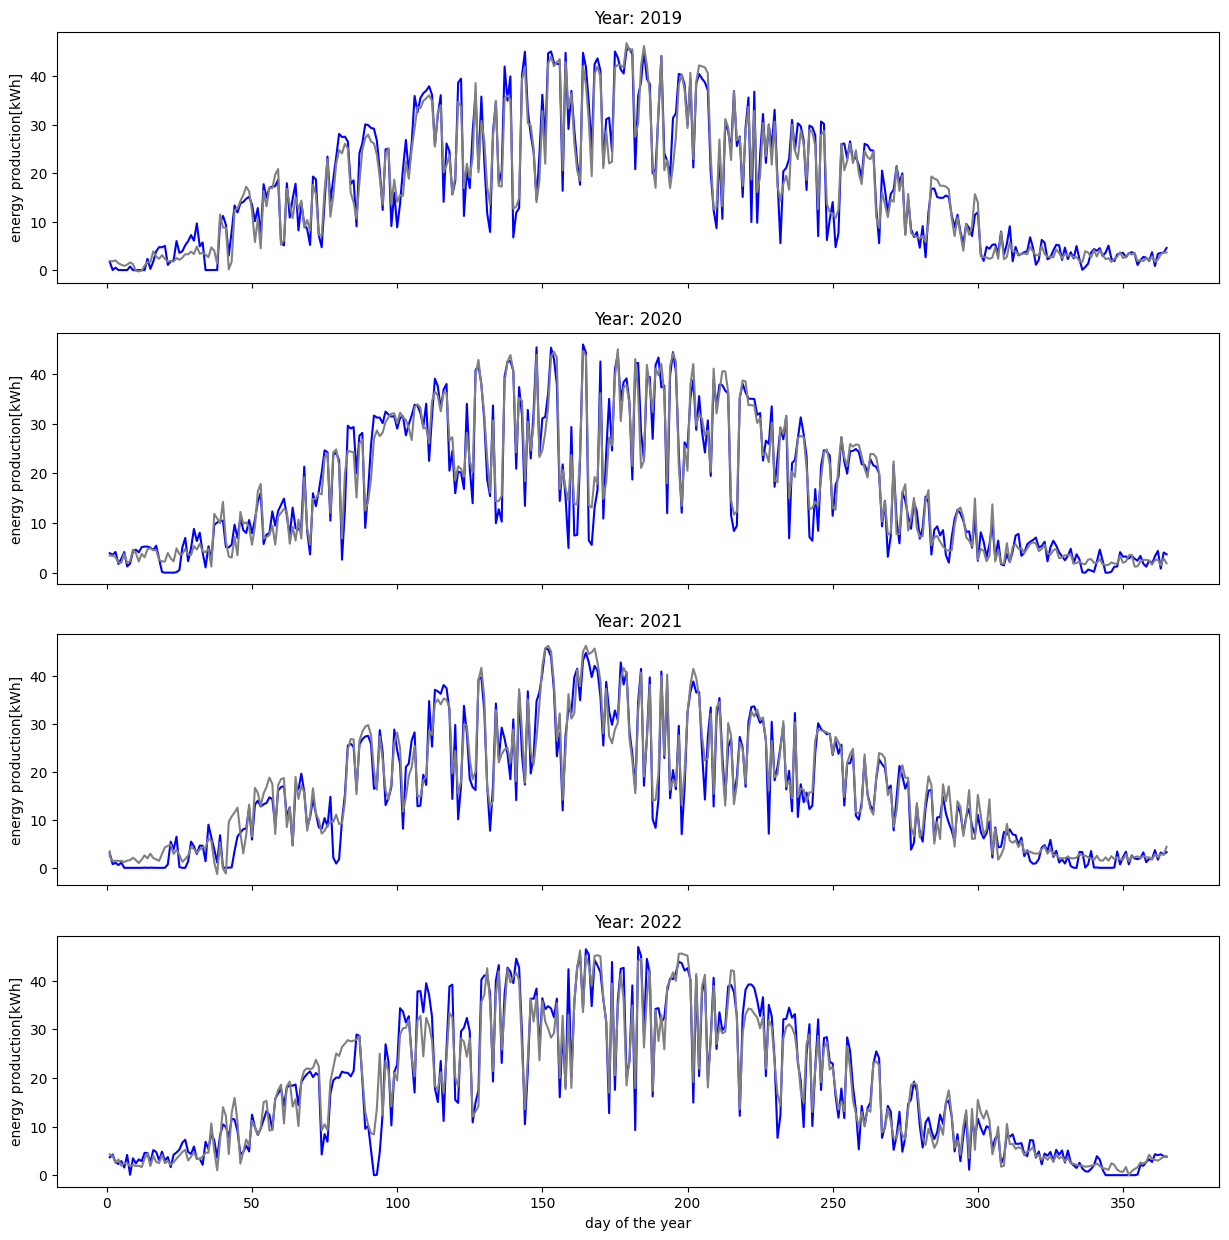

In [115]:
fig, axes = plt.subplots(4, 1, figsize=(15,15), sharex=True)
i = 0

for year in data['Year'].unique():
    ax = axes.flatten()[i]
    ax.set_title('Year: ' + str(year))
    year_data = data[data['Year'] == year]

    # plot energy production
    ax.plot(
        year_data['Day of year'],
        year_data['Gesamtanlage[kWh]'],
        color='blue'
    )

    X = year_data.drop(['RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Day', 'Month', 'Gesamtanlage[kWh]'], axis=1)
    pred_using_season = X.apply(reg_using_season, axis=1)

    #plot predictions
    ax.plot(
        year_data['Day of year'],
        pred_using_season,
        color='grey'
        )
        
    ax.set_ylabel('energy production[kWh]')
    i += 1


    # compute mean squared error:
    mse = mean_squared_error(year_data['Gesamtanlage[kWh]'], pred_using_season)
    print(f'For {year} the MSE is {mse:.2f}.')

    
axes[3].set_xlabel('day of the year')
plt.show()